# LR-LSTM for Stock Price Prediction (3 year Dataset)

### Importing the required libraries

Below are the libraries that are used to import data, graph plotting and Data Normalization

In [1]:
import scipy
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use for LSTM 
import tensorflow as tf

# Use for graph plotting
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline 

In [2]:
tf.random.set_seed(456)

### Load the financial history price of APPL using Pandas Library

Loading the data into pandas data frame is certainly one of the most important steps as we can view the data value from the excel data set. We need to read the excel file into a dataframe and the job will done by pandas data frame

In [3]:
dataframe = pd.read_csv("AAPL_3Y.csv",parse_dates = ['Date'],index_col = 'Date')

print("size: ",dataframe.shape)

# To display the top 10 rows
dataframe.head(10)

size:  (777, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-16,54.732498,55.747501,54.189999,55.537498,53.658726,116736000
2018-10-17,55.575001,55.660000,54.834999,55.297501,53.426846,91541600
2018-10-18,54.465000,54.935001,53.250000,54.005001,52.178062,130325200
2018-10-19,54.514999,55.314999,54.357498,54.827499,52.972744,132314800
2018-10-22,54.947498,55.840000,54.735001,55.162498,53.296410,115168400
2018-10-23,53.957500,55.812500,53.674999,55.682499,53.798817,155071200
2018-10-24,55.650002,56.057499,53.634998,53.772499,51.953426,163702000
2018-10-25,54.427502,55.345001,54.187500,54.950001,53.091099,119423200
2018-10-26,53.974998,55.047501,53.167500,54.075001,52.245701,189033600


### Display the historical prices of APPL stock in graph

Use the plot with figsize to set the size of the figure to a certain size. The y-axis of the graph is set to Close_Prices to show the closing prices of the stock

<function matplotlib.pyplot.show(close=None, block=None)>

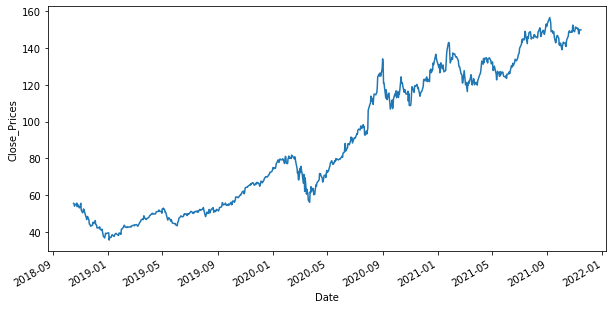

In [4]:
dataframe.Close.plot(figsize=(10,5))
plt.ylabel("Close_Prices")
plt.show

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 777 entries, 2018-10-16 to 2021-11-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       777 non-null    float64
 1   High       777 non-null    float64
 2   Low        777 non-null    float64
 3   Close      777 non-null    float64
 4   Adj Close  777 non-null    float64
 5   Volume     777 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 42.5 KB


In [6]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,777.000000,777.000000,777.000000,777.000000,777.000000,7.770000e+02
mean,89.777954,90.805895,88.769585,89.836715,88.870939,1.243223e+08
std,37.919964,38.266472,37.494989,37.888284,38.111473,5.991063e+07
min,35.994999,36.430000,35.500000,35.547501,34.464798,4.100000e+07
25%,52.189999,52.540001,51.762501,52.195000,50.991123,8.397360e+07
50%,79.457497,80.112503,78.912498,79.577499,78.539322,1.089533e+08
75%,126.250000,127.639999,125.010002,126.000000,125.370987,1.463228e+08
max,156.979996,157.259995,154.389999,156.690002,156.262573,4.265100e+08


### Set the split boundary to split the dataset

The code in the cell below set the training_size into 70% of total length of dataset. Then, dataset is split into 70% of training data and 30% testing data

Dimension of train data:  (543, 6)
Dimension of test data:  (234, 6)


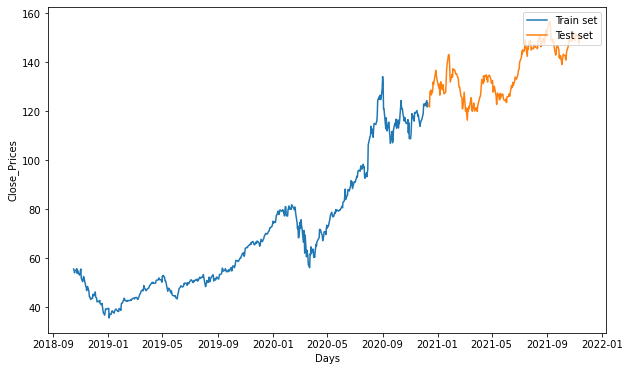

In [7]:
# Split train data and test data
training_size_LR = int(len(dataframe)*0.7)
train_dataset_LR, test_dataset_LR = dataframe.iloc[:training_size_LR], dataframe.iloc[training_size_LR:]

# Plot train and test data
plt.figure(figsize = (10,6))
plt.plot(train_dataset_LR.Close)
plt.plot(test_dataset_LR.Close)
plt.xlabel('Days')
plt.ylabel('Close_Prices')
plt.legend(['Train set','Test set'], loc='upper right')

print('Dimension of train data: ', train_dataset_LR.shape)
print('Dimension of test data: ', test_dataset_LR.shape)

## The data are available in a pre-processed form. The preprocessing includes the following:
1. Noise Removal.
2. Data Normalization. 


### Noise Removal

The "close price" and "adjusted closing prices" will be drop from the dataset to form the features training set. <br>
Only the "close price" will be selected to form the label training set

In [8]:
#Split train data for X and Y
train_dataset_LR = train_dataset_LR.reset_index().drop('Date',axis = 1)

X_train_LR = train_dataset_LR.drop(['Close','Adj Close'], axis = 1)
Y_train_LR = train_dataset_LR[['Close']]

#Split test data for X and Y
test_dataset_LR = test_dataset_LR.reset_index().drop('Date',axis = 1)

X_test_LR = test_dataset_LR.drop(['Close','Adj Close'], axis = 1)
Y_test_LR = test_dataset_LR[['Close']]

print(X_train_LR)
print(Y_test_LR)

           Open        High         Low     Volume
0     54.732498   55.747501   54.189999  116736000
1     55.575001   55.660000   54.834999   91541600
2     54.465000   54.935001   53.250000  130325200
3     54.514999   55.314999   54.357498  132314800
4     54.947498   55.840000   54.735001  115168400
..          ...         ...         ...        ...
538  122.599998  122.860001  121.519997   78260400
539  122.309998  124.570000  122.250000   86712000
540  124.370003  124.980003  123.089996   82225500
541  124.529999  125.949997  121.000000  115089200
542  120.500000  123.870003  120.150002   81312200

[543 rows x 4 columns]
          Close
0    122.410004
1    121.779999
2    127.879997
3    127.809998
4    128.699997
..          ...
229  150.809998
230  147.919998
231  147.869995
232  149.990005
233  150.000000

[234 rows x 1 columns]


### Data Normalization

Import the MinMaxScaler library from scikit-learn to perform the data normalization process. The value in each column will be translated into the range 0 and 1

In [9]:
#Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

#Fit the scaler using available training data
input_scaler_LR = scaler_x.fit(X_train_LR)
output_scaler_LR = scaler_y.fit(Y_train_LR)

#Apply the scaler to training data
X_train_normalize_LR = input_scaler_LR.transform(X_train_LR)
Y_train_normalize_LR = output_scaler_LR.transform(Y_train_LR)



#Different scaler for input and output
scaler_x_test = MinMaxScaler(feature_range = (0,1))
scaler_y_test = MinMaxScaler(feature_range = (0,1))

#Fit the scaler using available training data
input_scaler_test_LR = scaler_x_test.fit(X_test_LR)
output_scaler_test_LR = scaler_y_test.fit(Y_test_LR)

#Apply the scaler to test data
X_test_normalize_LR = input_scaler_test_LR.transform(X_test_LR)
Y_test_normalize_LR = output_scaler_test_LR.transform(Y_test_LR)



print('X_train_normalize.shape:', X_train_normalize_LR.shape)
print('Y_train_normalize.shape:', Y_train_normalize_LR.shape)
print('X_test_normalize.shape:', X_test_normalize_LR.shape)
print('Y_test_normalize.shape:', Y_test_normalize_LR.shape)

X_train_normalize.shape: (543, 4)
Y_train_normalize.shape: (543, 1)
X_test_normalize.shape: (234, 4)
Y_test_normalize.shape: (234, 1)


In [10]:
print("X_train_normalize: \n", X_train_normalize_LR)
print("Y_train_normalize: \n", Y_train_normalize_LR)
print("\n\n")
print("X_test_normalize: \n", X_test_normalize_LR)
print("Y_test_normalize: \n", Y_test_normalize_LR)

X_train_normalize: 
 [[0.18443328 0.19022651 0.19667473 0.18707717]
 [0.19272605 0.18936485 0.20346206 0.12096089]
 [0.1818003  0.18222552 0.18678312 0.22273856]
 ...
 [0.86987555 0.87198431 0.9217089  0.09651317]
 [0.87145039 0.88153619 0.89971589 0.18275556]
 [0.83178309 0.86105373 0.89077137 0.09411644]]
Y_train_normalize: 
 [[0.20267152]
 [0.20023827]
 [0.18713407]
 [0.19547309]
 [0.19886953]
 [0.20414163]
 [0.18477682]
 [0.19671509]
 [0.18784378]
 [0.17755305]
 [0.18023979]
 [0.1943325 ]
 [0.20284897]
 [0.16548804]
 [0.15055888]
 [0.15608447]
 [0.17174866]
 [0.16804807]
 [0.15785872]
 [0.13175171]
 [0.12683445]
 [0.11307126]
 [0.12475605]
 [0.13012952]
 [0.11068867]
 [0.08818086]
 [0.08767394]
 [0.07629329]
 [0.08219906]
 [0.08123591]
 [0.09821814]
 [0.09469496]
 [0.09223633]
 [0.10805264]
 [0.08744583]
 [0.08245254]
 [0.0666616 ]
 [0.06947509]
 [0.06701646]
 [0.06820776]
 [0.07289685]
 [0.05903225]
 [0.05512889]
 [0.06052773]
 [0.04739816]
 [0.03710744]
 [0.02164599]
 [0.01176082

### Import library required for linear regression

The class "sklearn.linear_model.LinearRegression(*, fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False)" is call to develop the linear regression model

The code in this cell also define and train the linear regression model using the training features and labels.

In [11]:
from sklearn.linear_model import LinearRegression

Multivariable_LR = LinearRegression()
Multivariable_LR.fit(X_train_normalize_LR, Y_train_normalize_LR)
Multivariable_LR.get_params(deep=True)

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [12]:
score = Multivariable_LR.score(X_train_normalize_LR,Y_train_normalize_LR)

print("Linear Score: ", score)
print("R2_score: ", '{:.2f}'.format(score*100))

Linear Score:  0.9993631445157947
R2_score:  99.94


In [13]:
Multivariable_LR.coef_

array([[-0.56434382,  0.88322584,  0.66356227, -0.0056397 ]])

In [14]:
# Make Prediction
def predict(model):
    prediction_of_LR = model.predict(X_test_normalize_LR)
    prediction_of_LR_readable = scaler_y_test.inverse_transform(prediction_of_LR)
    return prediction_of_LR_readable

prediction_of_LR_readable = predict(Multivariable_LR)


In [15]:
Y_test_read_LR = scaler_y_test.inverse_transform(Y_test_normalize_LR)
Y_train_read_LR = scaler_y.inverse_transform(Y_train_normalize_LR)

print(Y_test_read_LR)
print("\nPrediction\n")
print(prediction_of_LR_readable)

[[122.410004]
 [121.779999]
 [127.879997]
 [127.809998]
 [128.699997]
 [126.660004]
 [128.229996]
 [131.880005]
 [130.960007]
 [131.970001]
 [136.690002]
 [134.869995]
 [133.720001]
 [132.690002]
 [129.410004]
 [131.009995]
 [126.599998]
 [130.919998]
 [132.050003]
 [128.979996]
 [128.800003]
 [130.889999]
 [128.910004]
 [127.139999]
 [127.830002]
 [132.029999]
 [136.869995]
 [139.070007]
 [142.919998]
 [143.160004]
 [142.059998]
 [137.089996]
 [131.960007]
 [134.139999]
 [134.990005]
 [133.940002]
 [137.389999]
 [136.759995]
 [136.910004]
 [136.009995]
 [135.389999]
 [135.130005]
 [135.369995]
 [133.190002]
 [130.839996]
 [129.710007]
 [129.869995]
 [126.      ]
 [125.860001]
 [125.349998]
 [120.989998]
 [121.260002]
 [127.790001]
 [125.120003]
 [122.059998]
 [120.129997]
 [121.419998]
 [116.360001]
 [121.089996]
 [119.980003]
 [121.959999]
 [121.029999]
 [123.989998]
 [125.57    ]
 [124.760002]
 [120.529999]
 [119.989998]
 [123.389999]
 [122.540001]
 [120.089996]
 [120.589996]
 [121.

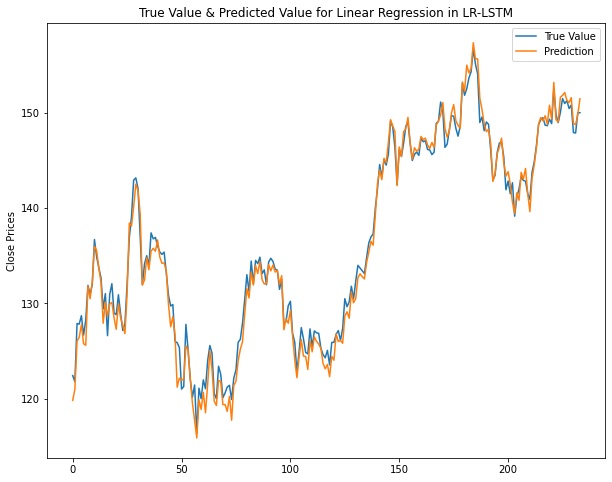

In [16]:
# Plot true future vs prediction
def plot_result(prediction, y_test, model_name):
    plt.figure(figsize = (10,8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Value')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.legend(loc='upper right')
    plt.title('True Value & Predicted Value for '+ model_name)
    plt.ylabel('Close Prices')
    
plot_result(prediction_of_LR_readable, Y_test_read_LR, 'Linear Regression in LR-LSTM')

In [17]:
#accuracy
print("Linear Score: ", Multivariable_LR.score(X_test_normalize_LR, Y_test_normalize_LR))

R2_score = Multivariable_LR.score(X_test_normalize_LR, Y_test_normalize_LR)*100
print('R2_score: {:.2f}'.format(R2_score))


Linear Score:  0.9867899297190331
R2_score: 98.68


### Calculate the performance metrics

The Mean Square Error, Root Mean Square Error, Mean Absolute Error and R-square is calculated in this function

In [18]:
import sklearn.metrics as sklm
import math

def print_metrics(y_true, y_predicted, year, model):
    print("This prediction model is: " + model)
    print("The size of dataset is: " + year)
    print('+-----------------------------+--------+')
    print('Mean Square Error (MSE)       = {:.4f}'.format(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error (RMSE) = {:.4f}'.format(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error (MAE)     = {:.4f}'.format(sklm.mean_absolute_error(y_true, y_predicted)))
    
    # R-squared evaluates the scatter of the data points around the fitted regression line. It is also called the coefficient of determination, or the coefficient of multiple determination for multiple regression. For the same data set, higher R-squared values represent smaller differences between the observed data and the fitted values.
    r2 = sklm.r2_score(y_true, y_predicted)
    print('R-square (R^2)                = {:.2f}'.format(r2*100))
    print('+-----------------------------+--------+')
    
    
print_metrics(Y_test_read_LR, prediction_of_LR_readable, "5-year", "LR") 

This prediction model is: LR
The size of dataset is: 5-year
+-----------------------------+--------+
Mean Square Error (MSE)       = 1.3465
Root Mean Square Error (RMSE) = 1.1604
Mean Absolute Error (MAE)     = 0.9030
R-square (R^2)                = 98.68
+-----------------------------+--------+


In [19]:
print("Shape of the Predicted value from LR: ", prediction_of_LR_readable.shape)
print("\nPredicted value from LR: ", prediction_of_LR_readable)


Shape of the Predicted value from LR:  (234, 1)

Predicted value from LR:  [[119.79933854]
 [120.97309895]
 [126.02480374]
 [126.42966129]
 [127.74852636]
 [125.75554155]
 [125.59058052]
 [131.80743176]
 [130.4772937 ]
 [132.25072056]
 [135.98377655]
 [135.53701982]
 [133.69057661]
 [132.20065988]
 [127.90158102]
 [130.11029079]
 [128.6220937 ]
 [129.90444417]
 [130.09772765]
 [128.45814396]
 [127.27124295]
 [129.96361746]
 [128.49215079]
 [127.68413461]
 [126.81387976]
 [131.04713739]
 [138.41196034]
 [138.10944822]
 [140.10165601]
 [142.49474186]
 [141.86010122]
 [139.36962479]
 [131.90778734]
 [132.452622  ]
 [134.77771319]
 [133.527088  ]
 [135.47386256]
 [135.76639395]
 [135.46125064]
 [136.64011892]
 [134.85324887]
 [134.1928471 ]
 [134.24148065]
 [133.36012954]
 [129.88735899]
 [127.52915328]
 [128.57963504]
 [126.69297559]
 [121.19778487]
 [122.14122854]
 [121.9265535 ]
 [122.06219735]
 [125.52983362]
 [125.07564226]
 [122.08789502]
 [119.52921057]
 [117.68745758]
 [115.8548740

In [20]:
print("Shape of the test set from LR: ", Y_test_read_LR.shape)
print("\nActual Value from test set in LR: ", Y_test_read_LR)


Shape of the test set from LR:  (234, 1)

Actual Value from test set in LR:  [[122.410004]
 [121.779999]
 [127.879997]
 [127.809998]
 [128.699997]
 [126.660004]
 [128.229996]
 [131.880005]
 [130.960007]
 [131.970001]
 [136.690002]
 [134.869995]
 [133.720001]
 [132.690002]
 [129.410004]
 [131.009995]
 [126.599998]
 [130.919998]
 [132.050003]
 [128.979996]
 [128.800003]
 [130.889999]
 [128.910004]
 [127.139999]
 [127.830002]
 [132.029999]
 [136.869995]
 [139.070007]
 [142.919998]
 [143.160004]
 [142.059998]
 [137.089996]
 [131.960007]
 [134.139999]
 [134.990005]
 [133.940002]
 [137.389999]
 [136.759995]
 [136.910004]
 [136.009995]
 [135.389999]
 [135.130005]
 [135.369995]
 [133.190002]
 [130.839996]
 [129.710007]
 [129.869995]
 [126.      ]
 [125.860001]
 [125.349998]
 [120.989998]
 [121.260002]
 [127.790001]
 [125.120003]
 [122.059998]
 [120.129997]
 [121.419998]
 [116.360001]
 [121.089996]
 [119.980003]
 [121.959999]
 [121.029999]
 [123.989998]
 [125.57    ]
 [124.760002]
 [120.529999]

In [21]:
Residual = Y_test_read_LR - prediction_of_LR_readable
Residual

array([[ 2.61066546e+00],
       [ 8.06900054e-01],
       [ 1.85519326e+00],
       [ 1.38033671e+00],
       [ 9.51470637e-01],
       [ 9.04462453e-01],
       [ 2.63941548e+00],
       [ 7.25732449e-02],
       [ 4.82713301e-01],
       [-2.80719555e-01],
       [ 7.06225455e-01],
       [-6.67024816e-01],
       [ 2.94243861e-02],
       [ 4.89342118e-01],
       [ 1.50842298e+00],
       [ 8.99704206e-01],
       [-2.02209570e+00],
       [ 1.01555383e+00],
       [ 1.95227535e+00],
       [ 5.21852040e-01],
       [ 1.52876005e+00],
       [ 9.26381536e-01],
       [ 4.17853210e-01],
       [-5.44135614e-01],
       [ 1.01612224e+00],
       [ 9.82861611e-01],
       [-1.54196534e+00],
       [ 9.60558780e-01],
       [ 2.81834199e+00],
       [ 6.65262141e-01],
       [ 1.99896778e-01],
       [-2.27962879e+00],
       [ 5.22196600e-02],
       [ 1.68737700e+00],
       [ 2.12291808e-01],
       [ 4.12913998e-01],
       [ 1.91613644e+00],
       [ 9.93601049e-01],
       [ 1.4

In [22]:
dataframe_for_LSTM = pd.DataFrame(Residual, columns=['Residual'])
dataframe_for_LSTM.index = pd.RangeIndex(543, 543+len(dataframe_for_LSTM))
dataframe_for_LSTM

,Residual
543,2.610665
544,0.806900
545,1.855193
546,1.380337
547,0.951471
...,...
772,-0.770236
773,-0.950257
774,-0.876642
775,0.162527


<function matplotlib.pyplot.show(close=None, block=None)>

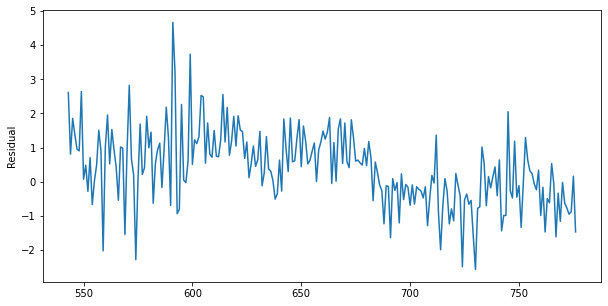

In [23]:
dataframe_for_LSTM.Residual.plot(figsize=(10,5))
plt.ylabel("Residual")
plt.show

Dimension of train data:  (163, 1)
Dimension of test data:  (71, 1)


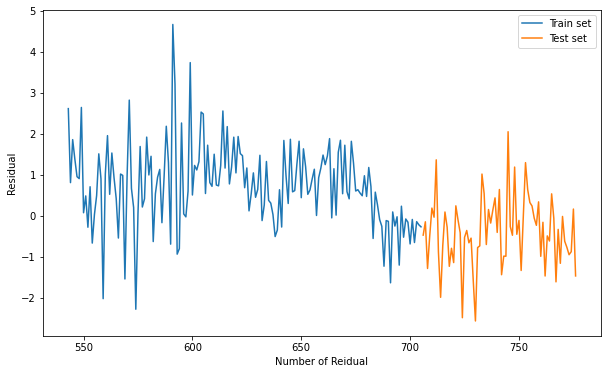

In [24]:
# Split train data and test data
training_size_LSTM = int(len(dataframe_for_LSTM)*0.7)
LSTM_train_dataset, LSTM_test_dataset = dataframe_for_LSTM.iloc[:training_size_LSTM], dataframe_for_LSTM.iloc[training_size_LSTM:]

# Plot train and test data
plt.figure(figsize = (10,6))
plt.plot(LSTM_train_dataset)
plt.plot(LSTM_test_dataset)
plt.xlabel('Number of Reidual')
plt.ylabel('Residual')
plt.legend(['Train set','Test set'], loc='upper right')

print('Dimension of train data: ', LSTM_train_dataset.shape)
print('Dimension of test data: ', LSTM_test_dataset.shape)

In [25]:
LSTM_train_dataset

,Residual
543,2.610665
544,0.806900
545,1.855193
546,1.380337
547,0.951471
...,...
701,-0.091183
702,-0.653257
703,-0.144528
704,-0.220981


In [26]:
#Split train data for X and Y
X_train_LSTM = LSTM_train_dataset
Y_train_LSTM = LSTM_train_dataset



#Split test data for X and Y
X_test_LSTM = LSTM_test_dataset
Y_test_LSTM = LSTM_test_dataset


print(X_train_LSTM)
print(Y_train_LSTM)
print(X_test_LSTM)
print(Y_test_LSTM)

     Residual
543  2.610665
544  0.806900
545  1.855193
546  1.380337
547  0.951471
..        ...
701 -0.091183
702 -0.653257
703 -0.144528
704 -0.220981
705 -0.271092

[163 rows x 1 columns]
     Residual
543  2.610665
544  0.806900
545  1.855193
546  1.380337
547  0.951471
..        ...
701 -0.091183
702 -0.653257
703 -0.144528
704 -0.220981
705 -0.271092

[163 rows x 1 columns]
     Residual
706 -0.473374
707 -0.147855
708 -1.285557
709 -0.494767
710  0.185961
..        ...
772 -0.770236
773 -0.950257
774 -0.876642
775  0.162527
776 -1.467916

[71 rows x 1 columns]
     Residual
706 -0.473374
707 -0.147855
708 -1.285557
709 -0.494767
710  0.185961
..        ...
772 -0.770236
773 -0.950257
774 -0.876642
775  0.162527
776 -1.467916

[71 rows x 1 columns]


In [27]:
#Different scaler for input and output


scaler_x_LSTM = MinMaxScaler(feature_range = (0,1))
scaler_y_LSTM = MinMaxScaler(feature_range = (0,1))

#FIt the scaler using available training data
input_scaler_LSTM = scaler_x_LSTM.fit(X_train_LSTM)
output_scaler_LSTM = scaler_y_LSTM.fit(Y_train_LSTM)

#Apply the scaler to training data
X_train_normalize_LSTM = input_scaler_LSTM.transform(X_train_LSTM)
Y_train_normalize_LSTM = output_scaler_LSTM.transform(Y_train_LSTM)



#Different scaler for input and output
scaler_x_LSTM_test = MinMaxScaler(feature_range = (0,1))
scaler_y_LSTM_test = MinMaxScaler(feature_range = (0,1))

#FIt the scaler using available training data
input_scaler_LSTM_test = scaler_x_LSTM_test.fit(X_test_LSTM)
output_scaler_LSTM_test = scaler_y_LSTM_test.fit(Y_test_LSTM)

#Apply the scaler to test data
X_test_normalize_LSTM = input_scaler_LSTM_test.transform(X_test_LSTM)
Y_test_normalize_LSTM = output_scaler_LSTM_test.transform(Y_test_LSTM)



print('X_train_normalize_LSTM.shape:', X_train_normalize_LSTM.shape)
print('Y_train_normalize_LSTM.shape:', Y_train_normalize_LSTM.shape)
print('X_test_normalize_LSTM.shape:', X_test_normalize_LSTM.shape)
print('Y_test_normalize_LSTM.shape:', Y_test_normalize_LSTM.shape)

X_train_normalize_LSTM.shape: (163, 1)
Y_train_normalize_LSTM.shape: (163, 1)
X_test_normalize_LSTM.shape: (71, 1)
Y_test_normalize_LSTM.shape: (71, 1)


In [28]:
print('X_test_normalize:\n', X_train_normalize_LSTM)
print('\nY_test_normalize:\n', Y_train_normalize_LSTM)
print('\nX_test_normalize:\n', X_test_normalize_LSTM)
print('\nY_test_normalize:\n', Y_test_normalize_LSTM)

X_test_normalize:
 [[0.70446608]
 [0.44462659]
 [0.59563734]
 [0.52723239]
 [0.46545255]
 [0.45868084]
 [0.70860763]
 [0.33884393]
 [0.39792622]
 [0.28795072]
 [0.43012402]
 [0.23230193]
 [0.33262817]
 [0.39888112]
 [0.54568372]
 [0.45799539]
 [0.03709865]
 [0.47468399]
 [0.6096224 ]
 [0.40356431]
 [0.54861336]
 [0.46183837]
 [0.38858287]
 [0.2500046 ]
 [0.47476587]
 [0.46997454]
 [0.10626331]
 [0.46676173]
 [0.73438269]
 [0.42422309]
 [0.35718539]
 [0.        ]
 [0.33591192]
 [0.57146275]
 [0.35897094]
 [0.38787135]
 [0.60441645]
 [0.4715216 ]
 [0.53708808]
 [0.23761765]
 [0.40571043]
 [0.46339074]
 [0.49095639]
 [0.30388193]
 [0.46562057]
 [0.64255001]
 [0.51427089]
 [0.22856362]
 [1.        ]
 [0.7906253 ]
 [0.19347498]
 [0.21283008]
 [0.65397545]
 [0.33477981]
 [0.3243708 ]
 [0.41493511]
 [0.86607657]
 [0.40115499]
 [0.504938  ]
 [0.48909295]
 [0.51828897]
 [0.69223706]
 [0.68563681]
 [0.40637452]
 [0.57606666]
 [0.44469095]
 [0.43159256]
 [0.54436839]
 [0.43621709]
 [0.43327482]
 

In [29]:
# Create a 3D input 
def create_3D_dataset(dataset, time_steps=1):
    X_dataset = []
    Y_dataset = []
    for i in range (len(dataset) - time_steps):
        V = dataset[i:(i+time_steps),0]
        X_dataset.append(V)
        Y_dataset.append(dataset[i+time_steps,0])
    return np.array(X_dataset), np.array(Y_dataset)

time_Steps = 30

X_train_LSTM, Y_train_LSTM = create_3D_dataset(X_train_normalize_LSTM, time_Steps)
X_test_LSTM, Y_test_LSTM = create_3D_dataset(X_test_normalize_LSTM, time_Steps)

print('X_train.shape_LSTM:', X_train_LSTM.shape)
print('Y_train.shape_LSTM:', Y_train_LSTM.shape)
print('X_test.shape_LSTM:', X_test_LSTM.shape)
print('Y_test.shape_LSTM:', Y_test_LSTM.shape)

X_train.shape_LSTM: (133, 30)
Y_train.shape_LSTM: (133,)
X_test.shape_LSTM: (41, 30)
Y_test.shape_LSTM: (41,)


In [30]:
X_train_LSTM = np.reshape(X_train_LSTM,(X_train_LSTM.shape[0],X_train_LSTM.shape[1],1))
X_test_LSTM = np.reshape(X_test_LSTM,(X_test_LSTM.shape[0],X_test_LSTM.shape[1],1))

print('X_train_LSTM.shape:', X_train_LSTM.shape)
print('X_test_LSTM.shape:', X_test_LSTM.shape)

Y_train_LSTM = np.reshape(Y_train_LSTM,(Y_train_LSTM.shape[0],1))
Y_test_LSTM = np.reshape(Y_test_LSTM,(Y_test_LSTM.shape[0],1))

print('Y_train_LSTM.shape:', Y_train_LSTM.shape)
print('Y_test_LSTM.shape:', Y_test_LSTM.shape)

X_train_LSTM.shape: (133, 30, 1)
X_test_LSTM.shape: (41, 30, 1)
Y_train_LSTM.shape: (133, 1)
Y_test_LSTM.shape: (41, 1)


In [31]:
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

def create_LSTM_model(units):
    model = Sequential()
    model.add(LSTM(units = units, return_sequences=True,input_shape=[X_train_LSTM.shape[1], X_train_LSTM.shape[2]]))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

LSTM_model = create_LSTM_model(64)

In [32]:
# Fit LSTM 
def fit_model(model):

    record = model.fit(X_train_LSTM, Y_train_LSTM, epochs = 200, validation_split = 0.2, batch_size = 64,
                      shuffle = False)
    return record

print("\n\nLSTM_record")
LSTM_record = fit_model(LSTM_model)



LSTM_record
Epoch 1/200
2/2 [==============================] - 4s 830ms/step - loss: 0.1723 - val_loss: 0.0249
Epoch 2/200
2/2 [==============================] - 0s 93ms/step - loss: 0.0703 - val_loss: 0.0089
Epoch 3/200
2/2 [==============================] - 0s 63ms/step - loss: 0.0235 - val_loss: 0.0614
Epoch 4/200
2/2 [==============================] - 0s 73ms/step - loss: 0.0543 - val_loss: 0.0439
Epoch 5/200
2/2 [==============================] - 0s 90ms/step - loss: 0.0338 - val_loss: 0.0160
Epoch 6/200
2/2 [==============================] - 0s 99ms/step - loss: 0.0202 - val_loss: 0.0074
Epoch 7/200
2/2 [==============================] - 0s 95ms/step - loss: 0.0226 - val_loss: 0.0064
Epoch 8/200
2/2 [==============================] - 0s 109ms/step - loss: 0.0289 - val_loss: 0.0065
Epoch 9/200
2/2 [==============================] - 0s 126ms/step - loss: 0.0314 - val_loss: 0.0065
Epoch 10/200
2/2 [==============================] - 0s 132ms/step - loss: 0.0301 - val_loss: 0.0075
E

2/2 [==============================] - 0s 152ms/step - loss: 0.0201 - val_loss: 0.0137
Epoch 83/200
2/2 [==============================] - 0s 133ms/step - loss: 0.0192 - val_loss: 0.0133
Epoch 84/200
2/2 [==============================] - 0s 125ms/step - loss: 0.0188 - val_loss: 0.0133
Epoch 85/200
2/2 [==============================] - 0s 128ms/step - loss: 0.0193 - val_loss: 0.0131
Epoch 86/200
2/2 [==============================] - 0s 151ms/step - loss: 0.0207 - val_loss: 0.0133
Epoch 87/200
2/2 [==============================] - 0s 126ms/step - loss: 0.0182 - val_loss: 0.0143
Epoch 88/200
2/2 [==============================] - 0s 108ms/step - loss: 0.0193 - val_loss: 0.0148
Epoch 89/200
2/2 [==============================] - 0s 142ms/step - loss: 0.0182 - val_loss: 0.0145
Epoch 90/200
2/2 [==============================] - 0s 130ms/step - loss: 0.0200 - val_loss: 0.0136
Epoch 91/200
2/2 [==============================] - 0s 109ms/step - loss: 0.0207 - val_loss: 0.0133
Epoch 92/200


2/2 [==============================] - 0s 111ms/step - loss: 0.0184 - val_loss: 0.0148
Epoch 164/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0205 - val_loss: 0.0149
Epoch 165/200
2/2 [==============================] - 0s 113ms/step - loss: 0.0195 - val_loss: 0.0158
Epoch 166/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0189 - val_loss: 0.0158
Epoch 167/200
2/2 [==============================] - 0s 112ms/step - loss: 0.0201 - val_loss: 0.0146
Epoch 168/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0209 - val_loss: 0.0145
Epoch 169/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0191 - val_loss: 0.0156
Epoch 170/200
2/2 [==============================] - 0s 108ms/step - loss: 0.0195 - val_loss: 0.0161
Epoch 171/200
2/2 [==============================] - 0s 108ms/step - loss: 0.0195 - val_loss: 0.0147
Epoch 172/200
2/2 [==============================] - 0s 111ms/step - loss: 0.0192 - val_loss: 0.0142
Epoc

In [33]:
# Make Prediction
def predict(model):
    prediction = model.predict(X_test_LSTM)
    prediction = scaler_x_LSTM_test.inverse_transform(prediction)
    return prediction

prediction_of_LSTM = predict(LSTM_model)

print(prediction_of_LSTM.shape)
print(prediction_of_LSTM)

(41, 1)
[[-0.5751875 ]
 [-0.52902627]
 [-0.4849027 ]
 [-0.44056976]
 [-0.3916354 ]
 [-0.35494894]
 [-0.31393164]
 [-0.30284557]
 [-0.3139157 ]
 [-0.33969784]
 [-0.3222636 ]
 [-0.3042443 ]
 [-0.29586646]
 [-0.268726  ]
 [-0.2511834 ]
 [-0.24052781]
 [-0.25437522]
 [-0.26762328]
 [-0.2549164 ]
 [-0.23147732]
 [-0.20572999]
 [-0.18264456]
 [-0.16814321]
 [-0.16432196]
 [-0.16044734]
 [-0.17677791]
 [-0.19597663]
 [-0.23683661]
 [-0.27813065]
 [-0.31832847]
 [-0.3366864 ]
 [-0.34389818]
 [-0.37078726]
 [-0.39334953]
 [-0.4232117 ]
 [-0.43992847]
 [-0.45291105]
 [-0.4679735 ]
 [-0.48653203]
 [-0.5064475 ]
 [-0.5066294 ]]


In [34]:
Y_test_read_LSTM = scaler_x_LSTM_test.inverse_transform(Y_test_LSTM) 
Y_train_read_LSTM = scaler_x_LSTM.inverse_transform(Y_train_LSTM)

print(Y_test_read_LSTM.shape)
print(Y_test_read_LSTM)

(41, 1)
[[ 1.51112643e-01]
 [-1.78926352e-01]
 [ 1.40504722e-01]
 [ 4.34604317e-01]
 [-4.06992676e-01]
 [ 6.38907867e-01]
 [-1.43793411e+00]
 [-9.85715167e-01]
 [-9.86999126e-01]
 [ 2.04775820e+00]
 [-2.65778064e-01]
 [-4.76378028e-01]
 [ 1.18607403e+00]
 [-4.52577640e-01]
 [-1.14460473e-01]
 [-1.33458862e+00]
 [ 1.29224168e-03]
 [ 1.29392914e+00]
 [ 6.36636904e-01]
 [ 3.21702178e-01]
 [ 2.36832091e-01]
 [-5.97392720e-02]
 [-2.34091321e-01]
 [ 3.37921492e-01]
 [-9.89664617e-01]
 [-1.59947678e-01]
 [-1.46969776e+00]
 [-4.91759375e-01]
 [-6.16326516e-01]
 [ 5.33140547e-01]
 [-6.32689861e-02]
 [-1.61230023e+00]
 [-3.33326896e-01]
 [-1.16008701e+00]
 [-1.77686670e-02]
 [-6.22601787e-01]
 [-7.70235845e-01]
 [-9.50257229e-01]
 [-8.76641598e-01]
 [ 1.62527386e-01]
 [-1.46791602e+00]]


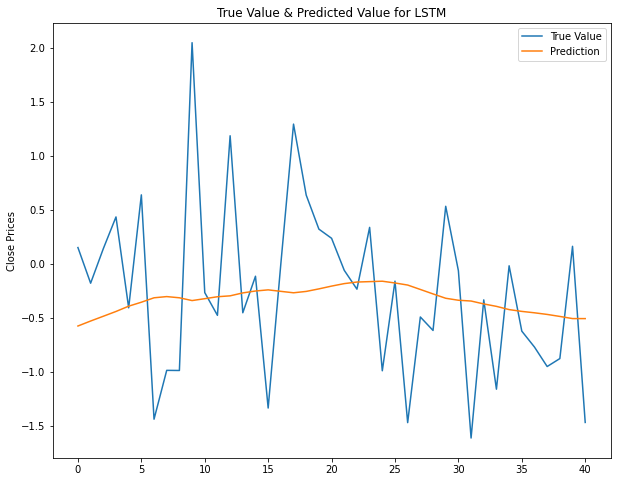

In [35]:
# Plot true future vs prediction
def plot_result(prediction, y_test, model_name):
    plt.figure(figsize = (10,8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Value')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.legend(loc='upper right')
    plt.title('True Value & Predicted Value for '+ model_name)
    plt.ylabel('Close Prices')
    
#plot_result(prediction_of_BidirectionLSTM, Y_test_read, 'BidirectionLSTM')
plot_result(prediction_of_LSTM, Y_test_read_LSTM, 'LSTM')

In [36]:
import sklearn.metrics as sklm
import math

def print_metrics(y_true, y_predicted, year, model):
    print("This prediction model is: " + model)
    print("The size of dataset is: " + year)
    print('+-----------------------------+--------+')
    print('Mean Square Error (MSE)       = {:.4f}'.format(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error (RMSE) = {:.4f}'.format(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error (MAE)     = {:.4f}'.format(sklm.mean_absolute_error(y_true, y_predicted)))
    print('+-----------------------------+--------+')
    
    
print_metrics(Y_test_read_LSTM, prediction_of_LSTM, "5-year",'LSTM') 


This prediction model is: LSTM
The size of dataset is: 5-year
+-----------------------------+--------+
Mean Square Error (MSE)       = 0.6286
Root Mean Square Error (RMSE) = 0.7928
Mean Absolute Error (MAE)     = 0.6169
+-----------------------------+--------+


In [37]:
print("The shape of Y_test_data:", Y_test_read_LSTM.shape)
print("Residual from LR prediction")
print(Y_test_read_LSTM)

print("The shape of LSTM_prediction_data:", prediction_of_LSTM.shape, "\n")
print("\n\nPredict Data from LSTM")
print(prediction_of_LSTM)

The shape of Y_test_data: (41, 1)
Residual from LR prediction
[[ 1.51112643e-01]
 [-1.78926352e-01]
 [ 1.40504722e-01]
 [ 4.34604317e-01]
 [-4.06992676e-01]
 [ 6.38907867e-01]
 [-1.43793411e+00]
 [-9.85715167e-01]
 [-9.86999126e-01]
 [ 2.04775820e+00]
 [-2.65778064e-01]
 [-4.76378028e-01]
 [ 1.18607403e+00]
 [-4.52577640e-01]
 [-1.14460473e-01]
 [-1.33458862e+00]
 [ 1.29224168e-03]
 [ 1.29392914e+00]
 [ 6.36636904e-01]
 [ 3.21702178e-01]
 [ 2.36832091e-01]
 [-5.97392720e-02]
 [-2.34091321e-01]
 [ 3.37921492e-01]
 [-9.89664617e-01]
 [-1.59947678e-01]
 [-1.46969776e+00]
 [-4.91759375e-01]
 [-6.16326516e-01]
 [ 5.33140547e-01]
 [-6.32689861e-02]
 [-1.61230023e+00]
 [-3.33326896e-01]
 [-1.16008701e+00]
 [-1.77686670e-02]
 [-6.22601787e-01]
 [-7.70235845e-01]
 [-9.50257229e-01]
 [-8.76641598e-01]
 [ 1.62527386e-01]
 [-1.46791602e+00]]
The shape of LSTM_prediction_data: (41, 1) 



Predict Data from LSTM
[[-0.5751875 ]
 [-0.52902627]
 [-0.4849027 ]
 [-0.44056976]
 [-0.3916354 ]
 [-0.35494894

In [38]:
print("The shape of LR_prediction_data: ",  prediction_of_LR_readable.shape)
print("\n\nPredict Data from LR: \n",  prediction_of_LR_readable)

The shape of LR_prediction_data:  (234, 1)


Predict Data from LR: 
 [[119.79933854]
 [120.97309895]
 [126.02480374]
 [126.42966129]
 [127.74852636]
 [125.75554155]
 [125.59058052]
 [131.80743176]
 [130.4772937 ]
 [132.25072056]
 [135.98377655]
 [135.53701982]
 [133.69057661]
 [132.20065988]
 [127.90158102]
 [130.11029079]
 [128.6220937 ]
 [129.90444417]
 [130.09772765]
 [128.45814396]
 [127.27124295]
 [129.96361746]
 [128.49215079]
 [127.68413461]
 [126.81387976]
 [131.04713739]
 [138.41196034]
 [138.10944822]
 [140.10165601]
 [142.49474186]
 [141.86010122]
 [139.36962479]
 [131.90778734]
 [132.452622  ]
 [134.77771319]
 [133.527088  ]
 [135.47386256]
 [135.76639395]
 [135.46125064]
 [136.64011892]
 [134.85324887]
 [134.1928471 ]
 [134.24148065]
 [133.36012954]
 [129.88735899]
 [127.52915328]
 [128.57963504]
 [126.69297559]
 [121.19778487]
 [122.14122854]
 [121.9265535 ]
 [122.06219735]
 [125.52983362]
 [125.07564226]
 [122.08789502]
 [119.52921057]
 [117.68745758]
 [115.85487409]
 [1

In [39]:
dataframe_prediction_of_LR = pd.DataFrame(prediction_of_LR_readable, columns=['residual_from_LR'])
dataframe_prediction_of_LR 

,residual_from_LR
0,119.799339
1,120.973099
2,126.024804
3,126.429661
4,127.748526
...,...
229,151.580234
230,148.870255
231,148.746637
232,149.827478


In [40]:
split_index = (int(len(dataframe_prediction_of_LR)*0.7)) + 30
predicted_value_from_LR = dataframe_prediction_of_LR.iloc[split_index:]

predicted_value_from_LR  = predicted_value_from_LR .to_numpy()
print("Shape of predicted value from LR: ", predicted_value_from_LR.shape)
print("Predicted value from LR: \n", predicted_value_from_LR )

Shape of predicted value from LR:  (41, 1)
Predicted value from LR: 
 [[142.78888936]
 [143.60891935]
 [145.70950128]
 [146.39539768]
 [147.32699068]
 [144.73108713]
 [143.34793811]
 [143.81571717]
 [142.48699913]
 [140.6022358 ]
 [139.40577706]
 [141.58637903]
 [140.81392597]
 [143.74257064]
 [143.01445447]
 [144.14458662]
 [141.50870276]
 [139.61607486]
 [143.1233581 ]
 [144.51829382]
 [146.31317091]
 [148.81973427]
 [149.49408632]
 [149.14207451]
 [149.67966662]
 [148.79994668]
 [150.78970476]
 [149.34176537]
 [153.18633352]
 [149.26686245]
 [149.02327599]
 [151.63230423]
 [151.8233319 ]
 [152.12009401]
 [151.29776767]
 [151.06260379]
 [151.58023385]
 [148.87025523]
 [148.7466366 ]
 [149.82747761]
 [151.46791602]]


In [41]:
predicted_y_hat = np.add(predicted_value_from_LR ,prediction_of_LSTM)
predicted_y_hat

array([[142.21370185],
       [143.07989308],
       [145.22459857],
       [145.95482792],
       [146.93535529],
       [144.3761382 ],
       [143.03400646],
       [143.5128716 ],
       [142.17308343],
       [140.26253797],
       [139.08351347],
       [141.28213472],
       [140.51805951],
       [143.47384465],
       [142.76327108],
       [143.90405881],
       [141.25432754],
       [139.34845159],
       [142.8684417 ],
       [144.2868165 ],
       [146.10744092],
       [148.63708971],
       [149.32594311],
       [148.97775255],
       [149.51921927],
       [148.62316876],
       [150.59372813],
       [149.10492876],
       [152.90820287],
       [148.94853398],
       [148.68658958],
       [151.28840606],
       [151.45254463],
       [151.72674448],
       [150.87455597],
       [150.62267531],
       [151.1273228 ],
       [148.40228173],
       [148.26010457],
       [149.32103012],
       [150.96128661]])

In [42]:
dataframe_Y_true_value_final = pd.DataFrame(Y_test_read_LR, columns=['True Value']) 
print(dataframe_Y_true_value_final)

     True Value
0    122.410004
1    121.779999
2    127.879997
3    127.809998
4    128.699997
..          ...
229  150.809998
230  147.919998
231  147.869995
232  149.990005
233  150.000000

[234 rows x 1 columns]


In [43]:
final_split = (int(len(dataframe_prediction_of_LR)*0.7)) + 30 

Y_true_value_final = dataframe_Y_true_value_final.iloc[final_split:]
Y_true_value_final = Y_true_value_final.to_numpy()

print("Shape of the Y true value for LR-LSTM: ", Y_true_value_final.shape)
print("The Y true value for LR-LSTM: \n", Y_true_value_final)

print("\n\nShape of final prediction for LR-LSTM(y-hat): ", predicted_y_hat.shape)

Shape of the Y true value for LR-LSTM:  (41, 1)
The Y true value for LR-LSTM: 
 [[142.940002]
 [143.429993]
 [145.850006]
 [146.830002]
 [146.919998]
 [145.369995]
 [141.910004]
 [142.830002]
 [141.5     ]
 [142.649994]
 [139.139999]
 [141.110001]
 [142.      ]
 [143.289993]
 [142.899994]
 [142.809998]
 [141.509995]
 [140.910004]
 [143.759995]
 [144.839996]
 [146.550003]
 [148.759995]
 [149.259995]
 [149.479996]
 [148.690002]
 [148.639999]
 [149.320007]
 [148.850006]
 [152.570007]
 [149.800003]
 [148.960007]
 [150.020004]
 [151.490005]
 [150.960007]
 [151.279999]
 [150.440002]
 [150.809998]
 [147.919998]
 [147.869995]
 [149.990005]
 [150.      ]]


Shape of final prediction for LR-LSTM(y-hat):  (41, 1)


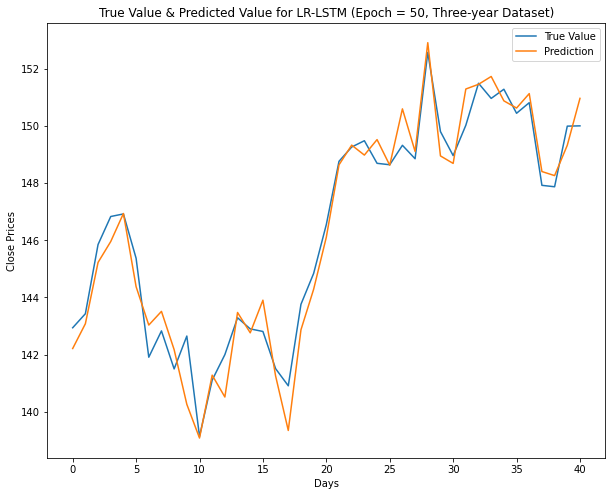

In [44]:
# Plot true future vs prediction
def plot_result(prediction, y_test, model_name):
    plt.figure(figsize = (10,8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Value')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.legend(loc='upper right')
    plt.title('True Value & Predicted Value for '+ model_name)
    plt.xlabel('Days')
    plt.ylabel('Close Prices')
    
#plot_result(prediction_of_BidirectionLSTM, Y_test_read, 'BidirectionLSTM')
plot_result(predicted_y_hat,Y_true_value_final, 'LR-LSTM (Epoch = 50, Three-year Dataset)')

In [45]:
import sklearn.metrics as sklm
import math

def print_metrics(y_true, y_predicted, year, model):
    print("This prediction model is: " + model)
    print("The size of dataset is: " + year)
    print('+-----------------------------+--------+')
    print('Mean Square Error (MSE)       = {:.4f}'.format(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error (RMSE) = {:.4f}'.format(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error (MAE)     = {:.4f}'.format(sklm.mean_absolute_error(y_true, y_predicted)))
    print('+-----------------------------+--------+')
    
    
print_metrics(Y_true_value_final, predicted_y_hat, "3-year",'LR-LSTM') 

This prediction model is: LR-LSTM
The size of dataset is: 3-year
+-----------------------------+--------+
Mean Square Error (MSE)       = 0.6286
Root Mean Square Error (RMSE) = 0.7928
Mean Absolute Error (MAE)     = 0.6169
+-----------------------------+--------+
